In [1]:
!pip install prophet


In [10]:
#import needed libs
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import numpy as np
import matplotlib.dates as mdates
from prophet import Prophet

from prophet.make_holidays import make_holidays_df


In [109]:
#data_set.  Clean data WITHOUT outliers 
df = pd.read_csv('data_no_outliers.csv')
df = df.set_index('Txn_date')
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df


,Invoice_id,Cust_id,Product_Sub_category,Product_Category,Qty,Rate,Tax,Total_Amt,Store_type
Txn_date,,,,,,,,,
2016-01-02,80348907828,267124,Computers,Electronics,2,552,115.920,1219.920,TeleShop
2016-01-02,45127479223,273949,Kids,Books,1,366,38.430,404.430,Brick and Mortar
2016-01-02,21830961921,267482,Audio and video,Electronics,4,455,191.100,2011.100,Brick and Mortar
2016-01-02,35789988197,267508,Mens,Clothing,3,783,246.645,2595.645,e-Shop
2016-01-02,4947037174,271239,Electric appliances,Home and kitchen,3,228,71.820,755.820,e-Shop
...,...,...,...,...,...,...,...,...,...
2018-12-31,26100869804,273836,Cameras,Electronics,3,843,265.545,2794.545,e-Shop
2018-12-31,83963970126,274655,Kids,Clothing,5,213,111.825,1176.825,e-Shop
2018-12-31,51849180620,273963,Cameras,Electronics,3,617,194.355,2045.355,e-Shop


In [4]:

df_sorted = df.sort_values("Total_Amt")
df_sorted.head()

,Invoice_id,Cust_id,Product_Sub_category,Product_Category,Qty,Rate,Tax,Total_Amt,Store_type
Txn_date,,,,,,,,,
2017-04-29,6409679426,267504,Kids,Footwear,1,70,7.350,77.350,TeleShop
2018-08-18,41885435954,272238,Kids,Books,1,70,7.350,77.350,TeleShop
2018-01-16,20826996132,271969,Kids,Clothing,1,70,7.350,77.350,e-Shop
2018-04-07,77308601183,268879,Mens,Clothing,1,71,7.455,78.455,Brick and Mortar
2018-12-27,16380694071,268284,Mens,Bags,1,71,7.455,78.455,e-Shop


In [5]:
#resample
df_daily = df.resample('D').sum().reset_index()


/var/folders/wd/2sf_363j2qgdyy46qr3rysph0000gn/T/ipykernel_59728/214196941.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily = df.resample('D').sum().reset_index()


In [110]:
df_daily_mean = df.resample('D').mean().reset_index()
df_daily_mean

/var/folders/wd/2sf_363j2qgdyy46qr3rysph0000gn/T/ipykernel_59728/1922812217.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily_mean = df.resample('D').mean().reset_index()


,Txn_date,Invoice_id,Cust_id,Qty,Rate,Tax,Total_Amt
0,2016-01-02,4.816472e+10,270473.347826,3.130435,752.391304,248.398043,2614.093696
1,2016-01-03,6.184703e+10,271073.166667,3.333333,666.333333,259.026250,2725.942917
2,2016-01-04,4.985095e+10,270151.000000,3.260870,812.304348,286.745870,3017.658913
3,2016-01-05,3.996963e+10,270722.090909,3.136364,808.545455,260.991818,2746.628182
4,2016-01-06,4.641065e+10,269576.882353,2.941176,824.000000,233.810294,2460.575000
...,...,...,...,...,...,...,...
1090,2018-12-27,4.460464e+10,270778.294118,3.117647,752.764706,243.285000,2560.285000
1091,2018-12-28,5.625562e+10,271647.888889,3.111111,747.777778,242.520833,2552.243056
1092,2018-12-29,3.803793e+10,270403.055556,2.833333,796.222222,237.889167,2503.500278
1093,2018-12-30,4.924039e+10,271246.352941,2.941176,921.235294,281.727353,2964.845000


In [14]:
df_daily.tail()

,Txn_date,Invoice_id,Cust_id,Qty,Rate,Tax,Total_Amt
1090,2018-12-27,758278844428,4603231,53,12797,4135.845,43524.845
1091,2018-12-28,1012601138841,4889662,56,13460,4365.375,45940.375
1092,2018-12-29,684682791456,4867255,51,14332,4282.005,45063.005
1093,2018-12-30,837086611250,4611188,50,15661,4789.365,50402.365
1094,2018-12-31,975993338037,4906505,57,12260,4133.220,43497.220


In [19]:
#checking for negative and zero values:
zero = (df_daily['Total_Amt'] == 0).any()
negatives = (df_daily['Total_Amt'] < 0).any()

print(zero)
print(negatives)

True
False


In [20]:
#rename columns
df_prophet = df_daily.rename(columns={'Txn_date': 'ds', 'Total_Amt': 'y'})


In [81]:
m = Prophet(daily_seasonality=False, changepoint_prior_scale=0.1)
m.add_seasonality(name='weekly', period=7, fourier_order=3)
m.add_country_holidays(country_name='US')
m.fit(df_prophet)


22:27:28 - cmdstanpy - INFO - Chain [1] start processing
22:27:28 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
#ONLHY daily seasonality, change point



m = Prophet(daily_seasonality=True, changepoint_prior_scale=0.1)

# adding custom weekly seasonality
m.add_seasonality(name='weekly', period=7, fourier_order=3)

# fit the model
m.fit(df_prophet)

22:25:54 - cmdstanpy - INFO - Chain [1] start processing
22:25:54 - cmdstanpy - INFO - Chain [1] done processing


In [82]:
#creating df to hold prediction
future = m.make_future_dataframe(periods=365) #  next year


In [83]:
#Prediction
forecast = m.predict(future)


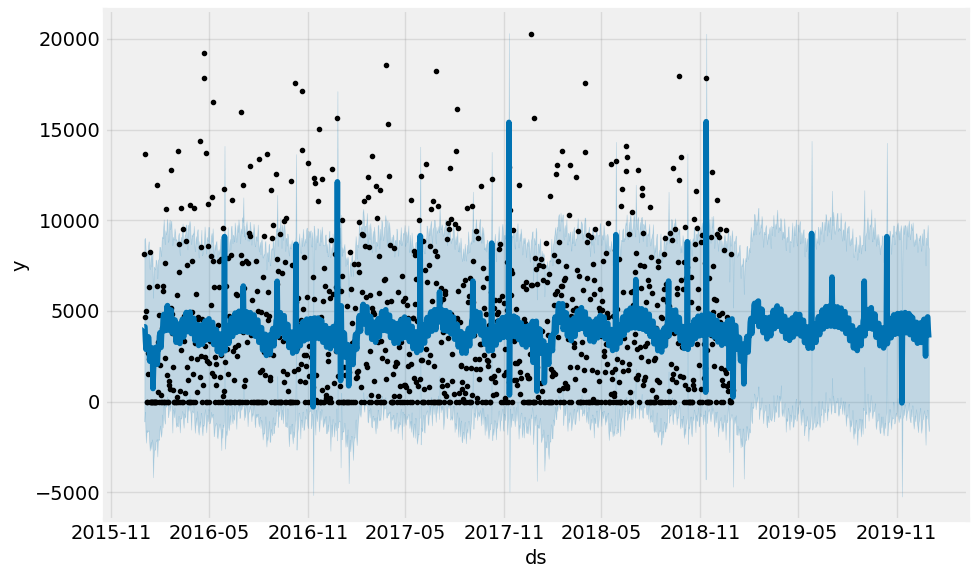

In [84]:
#plot the forecast
fig1 = m.plot(forecast)


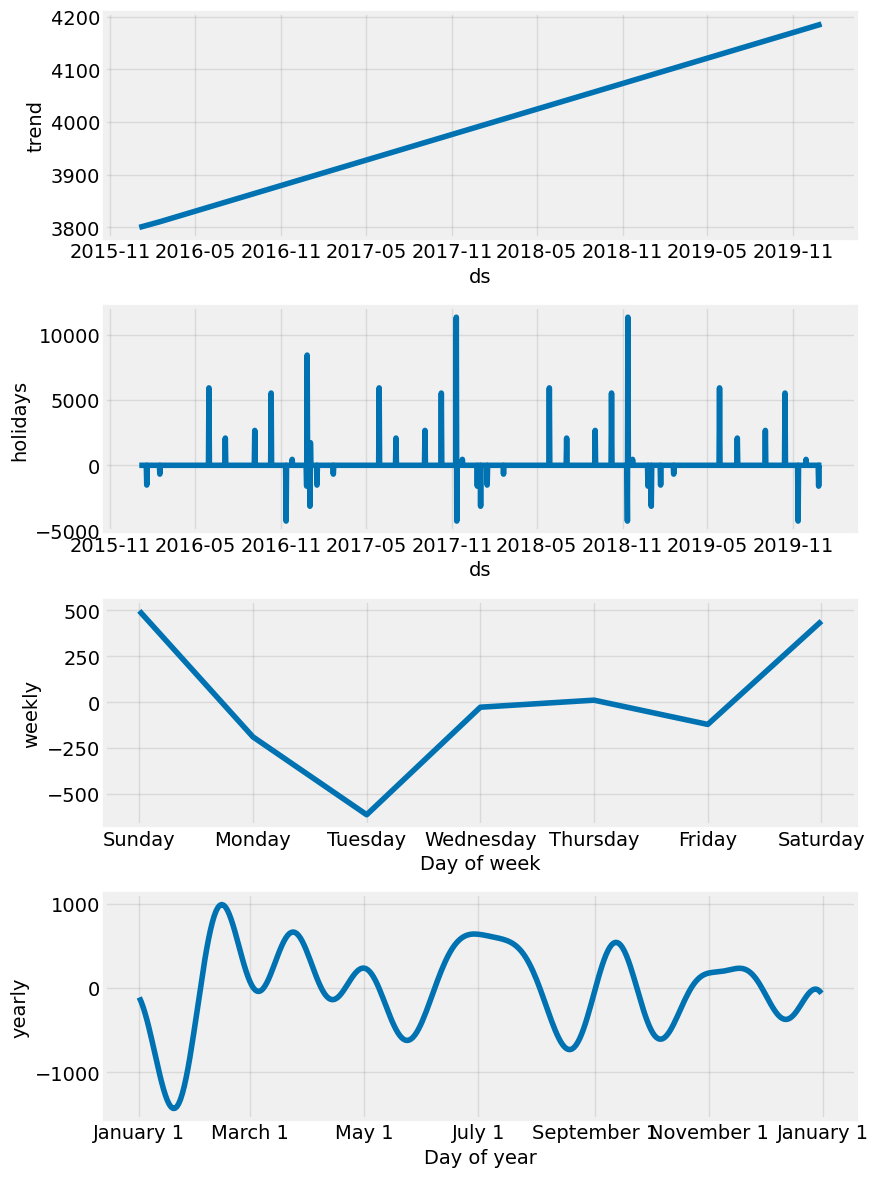

In [85]:
fig2 = m.plot_components(forecast)


In [86]:
# Initialize a dictionary to store the models
models = {}

In [87]:
# categories
unique_categories = df['Product_Category'].unique()
unique_categories

array(['Electronics', 'Books', 'Clothing', 'Home and kitchen', 'Footwear',
       'Bags'], dtype=object)

In [88]:
for category in unique_categories:
    # Filter the data
    df_filtered = df[df['Product_Category'] == category]
    df_daily = df_filtered.resample('D').sum().reset_index()
    
    df_prophet = df_daily.rename(columns={'Txn_date': 'ds', 'Total_Amt': 'y'})

    # Initialize and fit the model
    m = Prophet(daily_seasonality=True)
    m.fit(df_prophet)

    # Store the model
    models[category] = m

/var/folders/wd/2sf_363j2qgdyy46qr3rysph0000gn/T/ipykernel_59728/1178625639.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily = df_filtered.resample('D').sum().reset_index()
22:27:40 - cmdstanpy - INFO - Chain [1] start processing
22:27:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/wd/2sf_363j2qgdyy46qr3rysph0000gn/T/ipykernel_59728/1178625639.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily = df_filtered.resample('D').sum().reset_index()
22:27:40 - cmdstanpy - INFO - Chain [1] start processing
22:27:40 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/wd/2sf_

In [89]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-02,3799.746426,-1097.831551,8956.720657,3799.746426,3799.746426,0.0,0.0,0.0,0.0,...,440.952184,440.952184,440.952184,-122.470891,-122.470891,-122.470891,0.0,0.0,0.0,4118.227719
1,2016-01-03,3799.985851,-559.762074,9019.807228,3799.985851,3799.985851,0.0,0.0,0.0,0.0,...,496.831661,496.831661,496.831661,-175.603001,-175.603001,-175.603001,0.0,0.0,0.0,4121.214511
2,2016-01-04,3800.225276,-1692.420660,8557.853108,3800.225276,3800.225276,0.0,0.0,0.0,0.0,...,-188.743275,-188.743275,-188.743275,-238.671644,-238.671644,-238.671644,0.0,0.0,0.0,3372.810357
3,2016-01-05,3800.464702,-2267.727712,7950.922630,3800.464702,3800.464702,0.0,0.0,0.0,0.0,...,-612.124026,-612.124026,-612.124026,-310.949451,-310.949451,-310.949451,0.0,0.0,0.0,2877.391224
4,2016-01-06,3800.704127,-1577.846737,8230.239642,3800.704127,3800.704127,0.0,0.0,0.0,0.0,...,-27.202866,-27.202866,-27.202866,-391.445015,-391.445015,-391.445015,0.0,0.0,0.0,3382.056246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2019-12-27,4184.897169,-942.336499,8640.265141,4183.734432,4185.889737,0.0,0.0,0.0,0.0,...,-120.820573,-120.820573,-120.820573,-19.270924,-19.270924,-19.270924,0.0,0.0,0.0,4044.805673
1456,2019-12-28,4185.162500,-453.426476,9248.462805,4183.996833,4186.160404,0.0,0.0,0.0,0.0,...,440.952184,440.952184,440.952184,-12.425704,-12.425704,-12.425704,0.0,0.0,0.0,4613.688980
1457,2019-12-29,4185.427830,-477.321814,9733.399769,4184.258003,4186.428812,0.0,0.0,0.0,0.0,...,496.831661,496.831661,496.831661,-14.370034,-14.370034,-14.370034,0.0,0.0,0.0,4667.889456
1458,2019-12-30,4185.693160,-1200.321922,8549.340728,4184.517203,4186.696831,0.0,0.0,0.0,0.0,...,-188.743275,-188.743275,-188.743275,-25.891747,-25.891747,-25.891747,0.0,0.0,0.0,3971.058138


In [90]:
# Initialize a dictionary to store the forecasts
forecasts = {}

for category, model in models.items():
    # Create future dataframe
    future = model.make_future_dataframe(periods=365)

    # Predict
    forecast = model.predict(future)

    # Store the forecast
    forecasts[category] = forecast


Forecast for category: Electronics


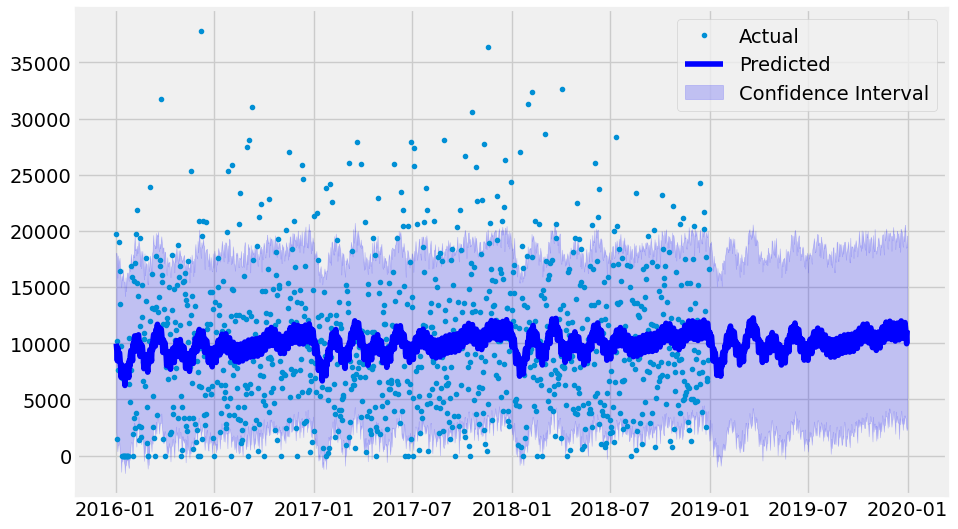

Forecast for category: Books


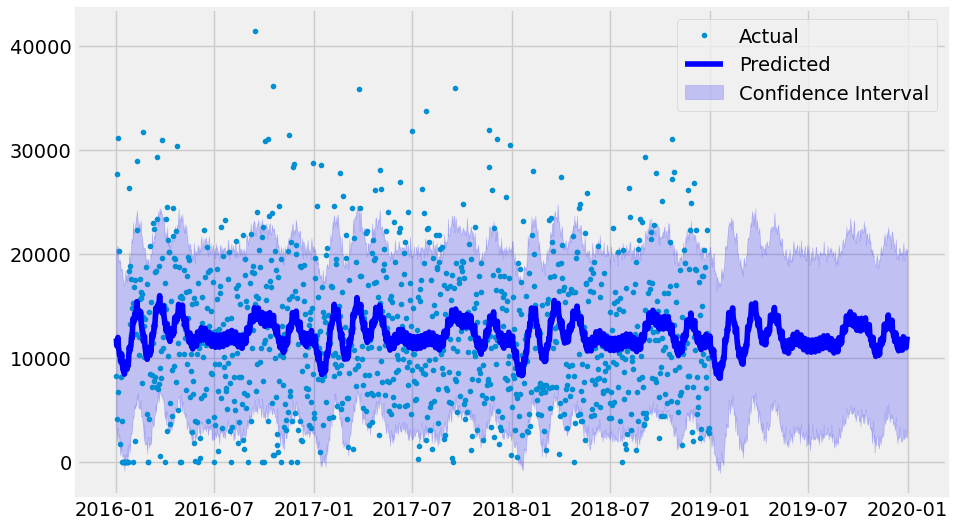

Forecast for category: Clothing


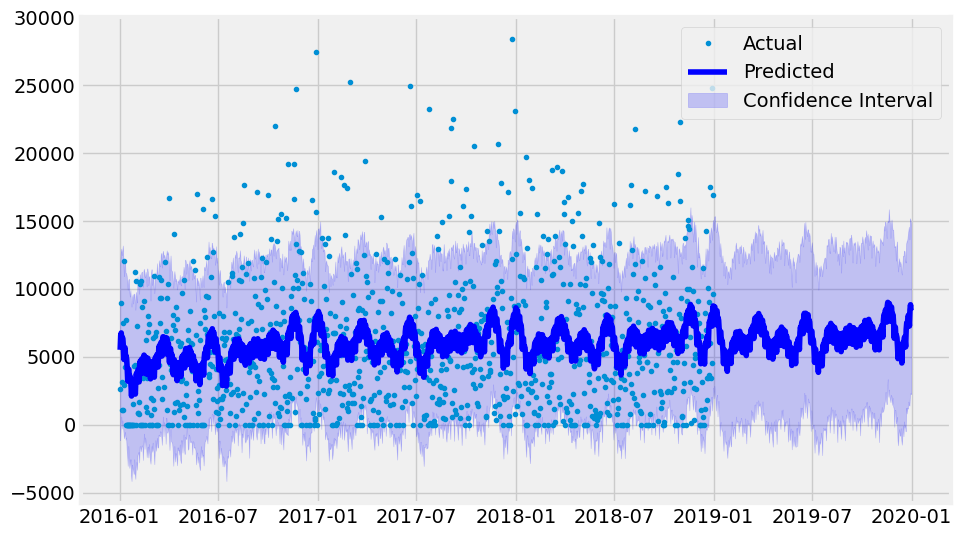

Forecast for category: Home and kitchen


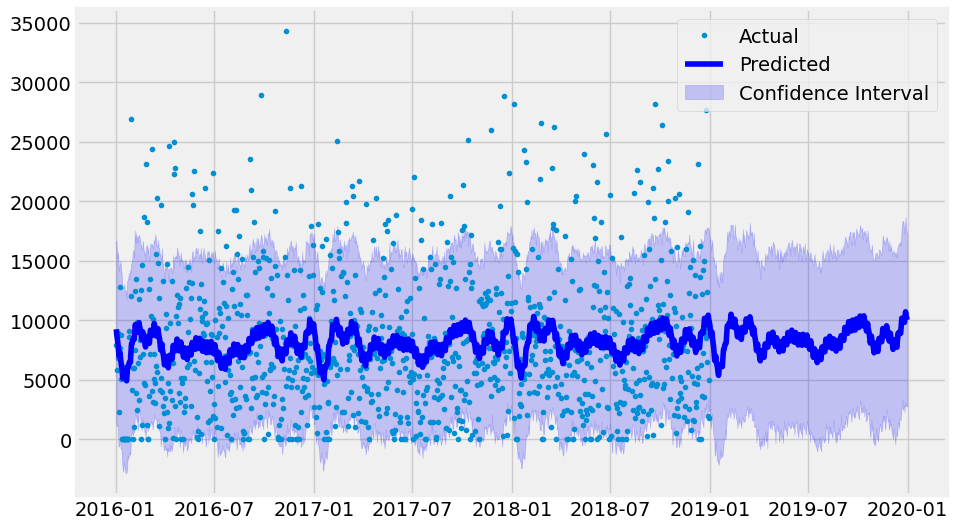

Forecast for category: Footwear


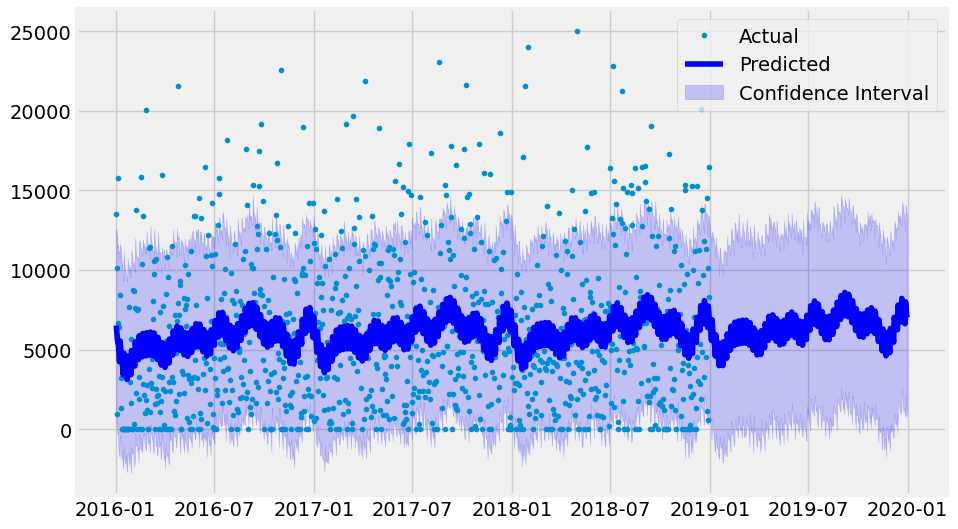

Forecast for category: Bags


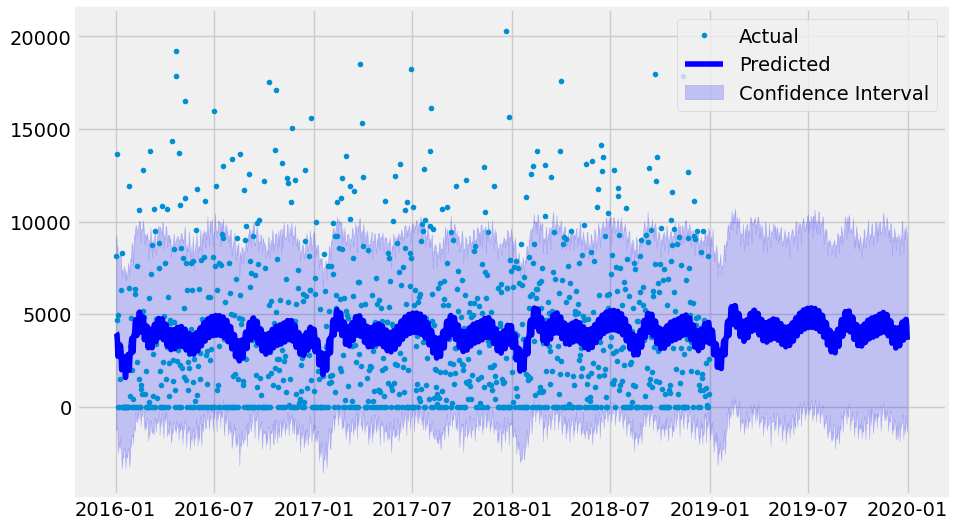

In [91]:
#Forecast for each category:

for category, forecast in forecasts.items():
    print(f"Forecast for category: {category}")
    model = models[category]
    
    fig = plt.figure(facecolor='w', figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(model.history['ds'], model.history['y'], '.', label='Actual')
    ax.plot(forecast['ds'], forecast['yhat'], ls='-', c='blue', label='Predicted')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')
    ax.legend(loc='best')
    plt.show()  


In [92]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-02,7239.381723,-1246.162051,9216.486549,7239.381723,7239.381723,-3260.849689,-3260.849689,-3260.849689,-3454.146027,...,366.362587,366.362587,366.362587,-173.066249,-173.066249,-173.066249,0.0,0.0,0.0,3978.532033
1,2016-01-03,7239.757264,-1085.035613,8482.960673,7239.757264,7239.757264,-3303.406761,-3303.406761,-3303.406761,-3454.146027,...,392.037714,392.037714,392.037714,-241.298447,-241.298447,-241.298447,0.0,0.0,0.0,3936.350503
2,2016-01-04,7240.132805,-1287.658567,8717.460580,7240.132805,7240.132805,-3662.537581,-3662.537581,-3662.537581,-3454.146027,...,111.701500,111.701500,111.701500,-320.093054,-320.093054,-320.093054,0.0,0.0,0.0,3577.595224
3,2016-01-05,7240.508346,-2514.881784,8055.086029,7240.508346,7240.508346,-4519.105056,-4519.105056,-4519.105056,-3454.146027,...,-656.672666,-656.672666,-656.672666,-408.286363,-408.286363,-408.286363,0.0,0.0,0.0,2721.403289
4,2016-01-06,7240.883887,-2021.256211,8084.916233,7240.883887,7240.883887,-4020.144665,-4020.144665,-4020.144665,-3454.146027,...,-61.553978,-61.553978,-61.553978,-504.444660,-504.444660,-504.444660,0.0,0.0,0.0,3220.739221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2019-12-27,7785.725953,-1408.304828,9039.415757,7785.723470,7785.728326,-3591.032616,-3591.032616,-3591.032616,-3454.146027,...,-123.757322,-123.757322,-123.757322,-13.129267,-13.129267,-13.129267,0.0,0.0,0.0,4194.693338
1456,2019-12-28,7786.101438,-469.086301,9803.583071,7786.098949,7786.103818,-3098.047436,-3098.047436,-3098.047436,-3454.146027,...,366.362587,366.362587,366.362587,-10.263996,-10.263996,-10.263996,0.0,0.0,0.0,4688.054002
1457,2019-12-29,7786.476922,-806.623331,9450.470873,7786.474421,7786.479311,-3080.776914,-3080.776914,-3080.776914,-3454.146027,...,392.037714,392.037714,392.037714,-18.668601,-18.668601,-18.668601,0.0,0.0,0.0,4705.700008
1458,2019-12-30,7786.852407,-1079.489761,9388.570220,7786.849894,7786.854808,-3381.405794,-3381.405794,-3381.405794,-3454.146027,...,111.701500,111.701500,111.701500,-38.961267,-38.961267,-38.961267,0.0,0.0,0.0,4405.446613


In [93]:
df_daily.head()

,Txn_date,Invoice_id,Cust_id,Qty,Rate,Tax,Total_Amt
0,2016-01-02,117643988025,546297,9,1574,770.595,8109.595
1,2016-01-03,30501471458,270632,5,847,444.675,4679.675
2,2016-01-04,146194651928,813260,13,2827,1295.280,13631.280
3,2016-01-05,32992559875,274470,4,1125,472.500,4972.500
4,2016-01-06,0,0,0,0,0.000,0.000


In [94]:
#merging two df's
merged = df_daily.join(forecast[['yhat', 'yhat_lower', 'yhat_upper']], how = 'inner')


In [95]:
merged[['Total_Amt', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,Total_Amt,yhat,yhat_lower,yhat_upper
0,8109.595,3978.532033,-1246.162051,9216.486549
1,4679.675,3936.350503,-1085.035613,8482.960673
2,13631.280,3577.595224,-1287.658567,8717.460580
3,4972.500,2721.403289,-2514.881784,8055.086029
4,0.000,3220.739221,-2021.256211,8084.916233


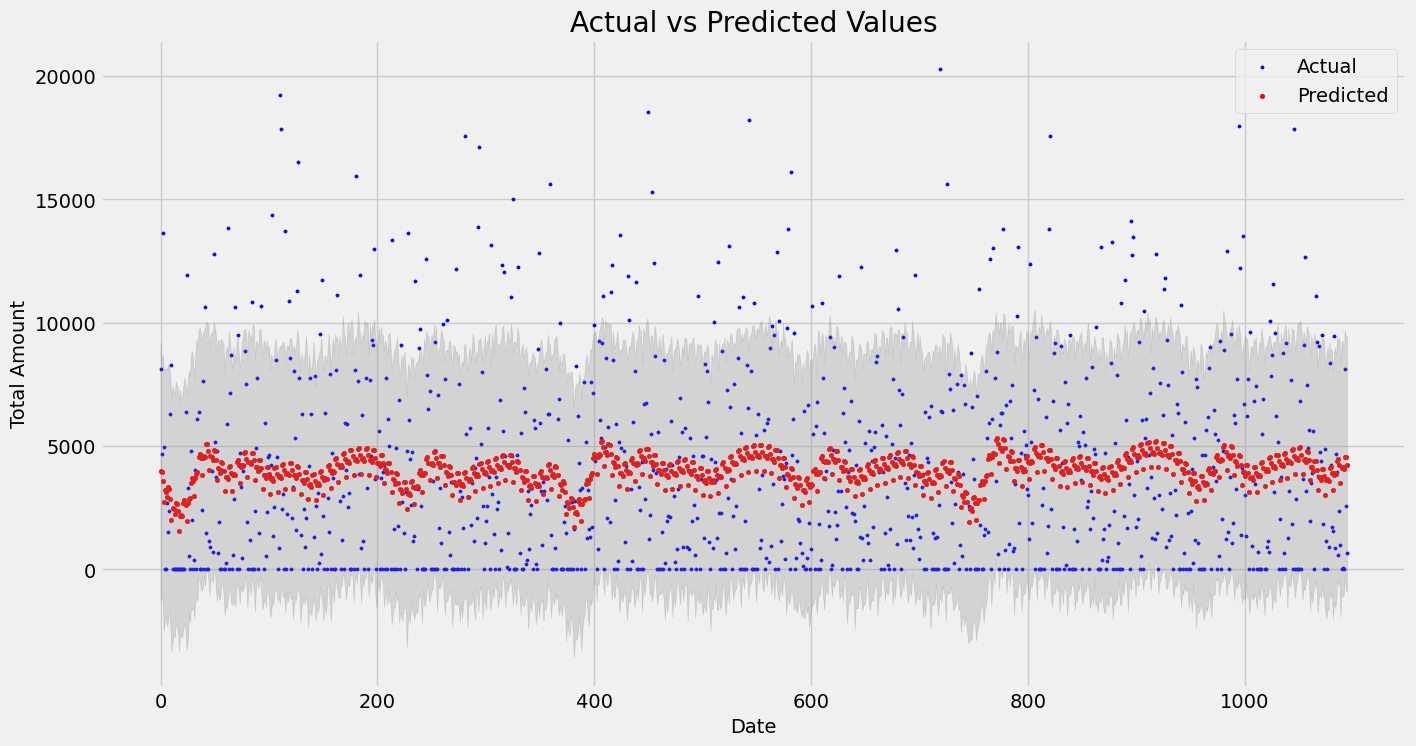

In [96]:

plt.figure(figsize=(15,8))

# Plot the actual data
plt.scatter(merged.index, merged['Total_Amt'], color='blue', label='Actual', s=5)

# Plot the predicted data
plt.scatter(merged.index, merged['yhat'], color='red', label='Predicted', s=10)
# plot the upper and lower boundaries of confidence intervals
plt.fill_between(merged.index, merged['yhat_lower'], merged['yhat_upper'], color='gray', alpha=0.25)

plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Actual vs Predicted Values')
plt.legend()

plt.show()



In [97]:
merged.to_csv('merged_test')

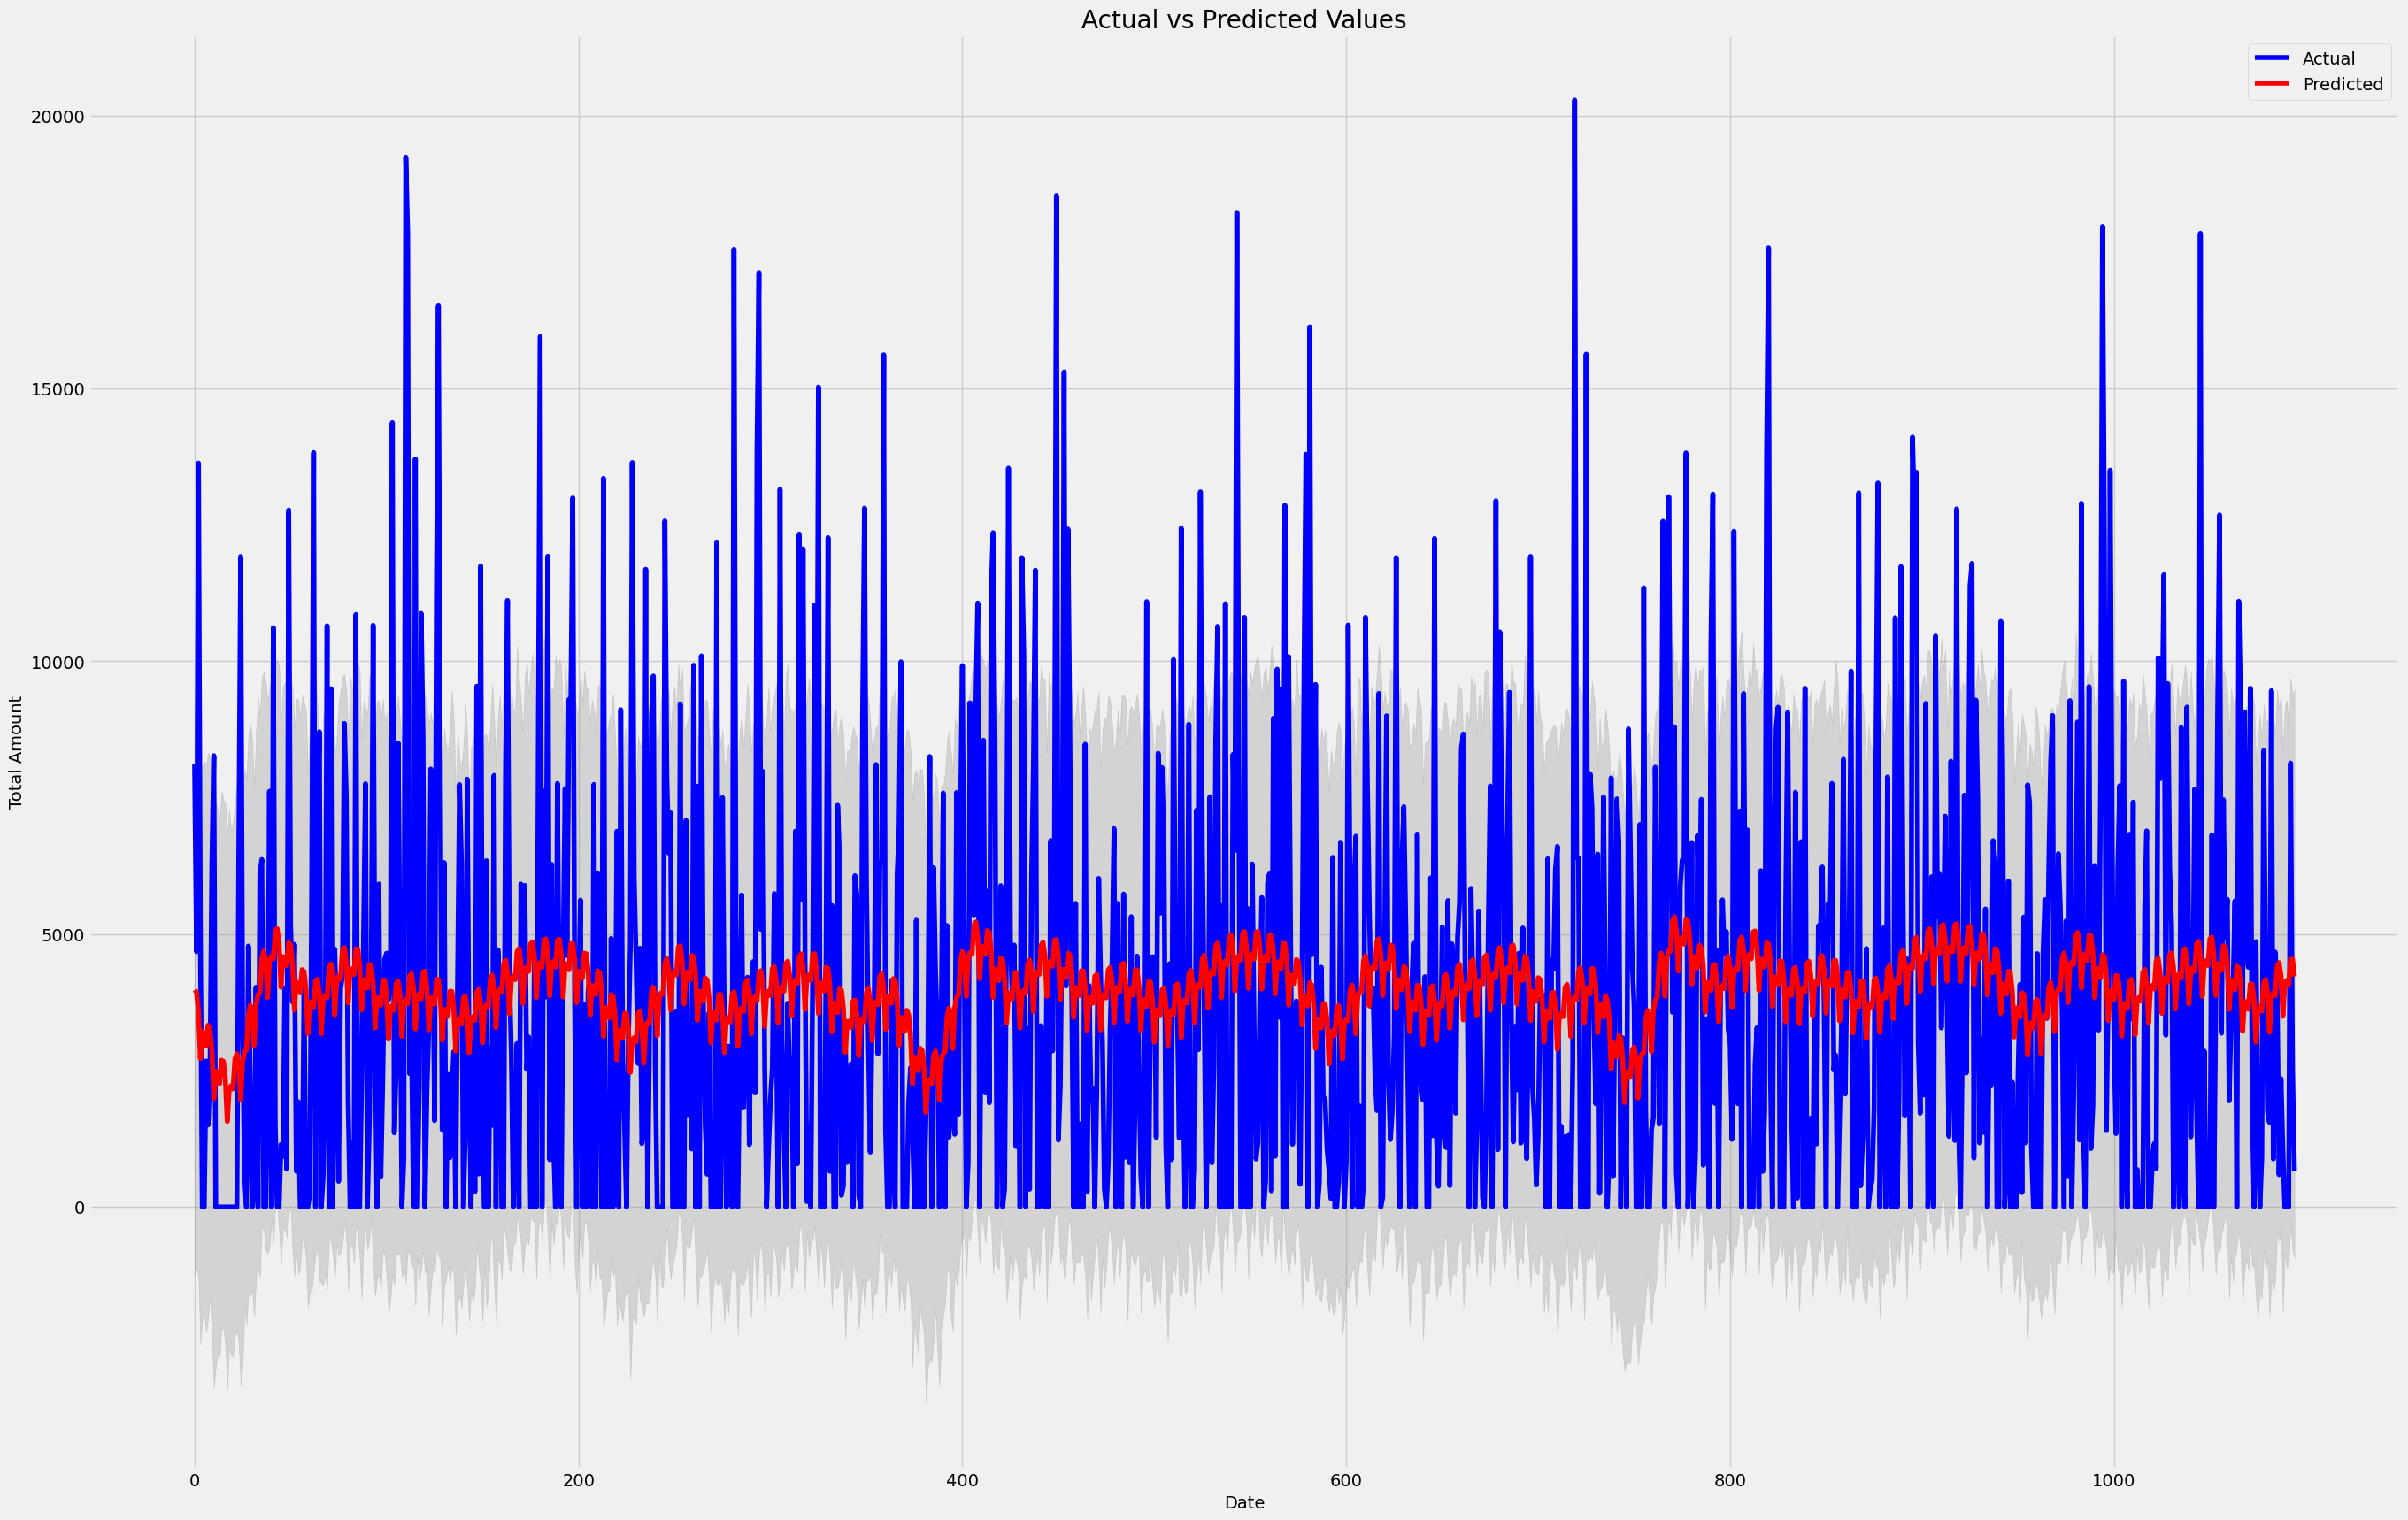

In [98]:
plt.figure(figsize=(30,20))

# plot the actual data
plt.plot(merged.index, merged['Total_Amt'], 'b-', label='Actual')

# plot the forecast 
plt.plot(merged.index, merged['yhat'], 'r-', label='Predicted')

# plot the upper and lower boundaries of confidence intervals
plt.fill_between(merged.index, merged['yhat_lower'], merged['yhat_upper'], color='gray', alpha=0.25)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Actual vs Predicted Values')

plt.show()

#RMSE check
'''
the average difference between the actual and predicted daily total sales

'''

In [99]:
#to be safe let's make a copy of df "clean_data"
clean_data = df_daily.copy()

In [100]:
#rename Txn_date column to ds for merge
clean_data.rename(columns={'Txn_date': 'ds'}, inplace=True)

In [101]:
#converting df in forecast datase
forecast['ds'] = pd.to_datetime(forecast['ds'])

In [102]:
merged_rmse = pd.merge(forecast, clean_data, on='ds', how='inner')

In [103]:
merged_rmse['diff_squared'] = (merged_rmse['yhat'] - merged_rmse['Total_Amt'])**2

In [104]:
mean_diff_squared = merged_rmse['diff_squared'].mean()

In [105]:
rmse = np.sqrt(mean_diff_squared)
rmse

3963.024095469102

In [106]:
# The difference between actual sales and prediction is almost $4000. I duno

In [111]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-02,7239.381723,-1246.162051,9216.486549,7239.381723,7239.381723,-3260.849689,-3260.849689,-3260.849689,-3454.146027,...,366.362587,366.362587,366.362587,-173.066249,-173.066249,-173.066249,0.0,0.0,0.0,3978.532033
1,2016-01-03,7239.757264,-1085.035613,8482.960673,7239.757264,7239.757264,-3303.406761,-3303.406761,-3303.406761,-3454.146027,...,392.037714,392.037714,392.037714,-241.298447,-241.298447,-241.298447,0.0,0.0,0.0,3936.350503
2,2016-01-04,7240.132805,-1287.658567,8717.460580,7240.132805,7240.132805,-3662.537581,-3662.537581,-3662.537581,-3454.146027,...,111.701500,111.701500,111.701500,-320.093054,-320.093054,-320.093054,0.0,0.0,0.0,3577.595224
3,2016-01-05,7240.508346,-2514.881784,8055.086029,7240.508346,7240.508346,-4519.105056,-4519.105056,-4519.105056,-3454.146027,...,-656.672666,-656.672666,-656.672666,-408.286363,-408.286363,-408.286363,0.0,0.0,0.0,2721.403289
4,2016-01-06,7240.883887,-2021.256211,8084.916233,7240.883887,7240.883887,-4020.144665,-4020.144665,-4020.144665,-3454.146027,...,-61.553978,-61.553978,-61.553978,-504.444660,-504.444660,-504.444660,0.0,0.0,0.0,3220.739221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2019-12-27,7785.725953,-1408.304828,9039.415757,7785.723470,7785.728326,-3591.032616,-3591.032616,-3591.032616,-3454.146027,...,-123.757322,-123.757322,-123.757322,-13.129267,-13.129267,-13.129267,0.0,0.0,0.0,4194.693338
1456,2019-12-28,7786.101438,-469.086301,9803.583071,7786.098949,7786.103818,-3098.047436,-3098.047436,-3098.047436,-3454.146027,...,366.362587,366.362587,366.362587,-10.263996,-10.263996,-10.263996,0.0,0.0,0.0,4688.054002
1457,2019-12-29,7786.476922,-806.623331,9450.470873,7786.474421,7786.479311,-3080.776914,-3080.776914,-3080.776914,-3454.146027,...,392.037714,392.037714,392.037714,-18.668601,-18.668601,-18.668601,0.0,0.0,0.0,4705.700008
1458,2019-12-30,7786.852407,-1079.489761,9388.570220,7786.849894,7786.854808,-3381.405794,-3381.405794,-3381.405794,-3454.146027,...,111.701500,111.701500,111.701500,-38.961267,-38.961267,-38.961267,0.0,0.0,0.0,4405.446613


#3. Forecasting summary

We have used the Facebook Prophet library to build our forecasting model. This model has been configured to account for daily seasonality. To advance our forecasting efforts, we have generated separate forecasts for each category.

Evaluation of the model: We have utilized the Root Mean Square Error (RMSE) to measure the accuracy of our forecasts.

Challenges: The current forecast does not provide a clear picture. The RMSE (which measures the difference between actual sales and predicted sales) for our forecast is approximately $4000, indicating a substantial discrepancy.

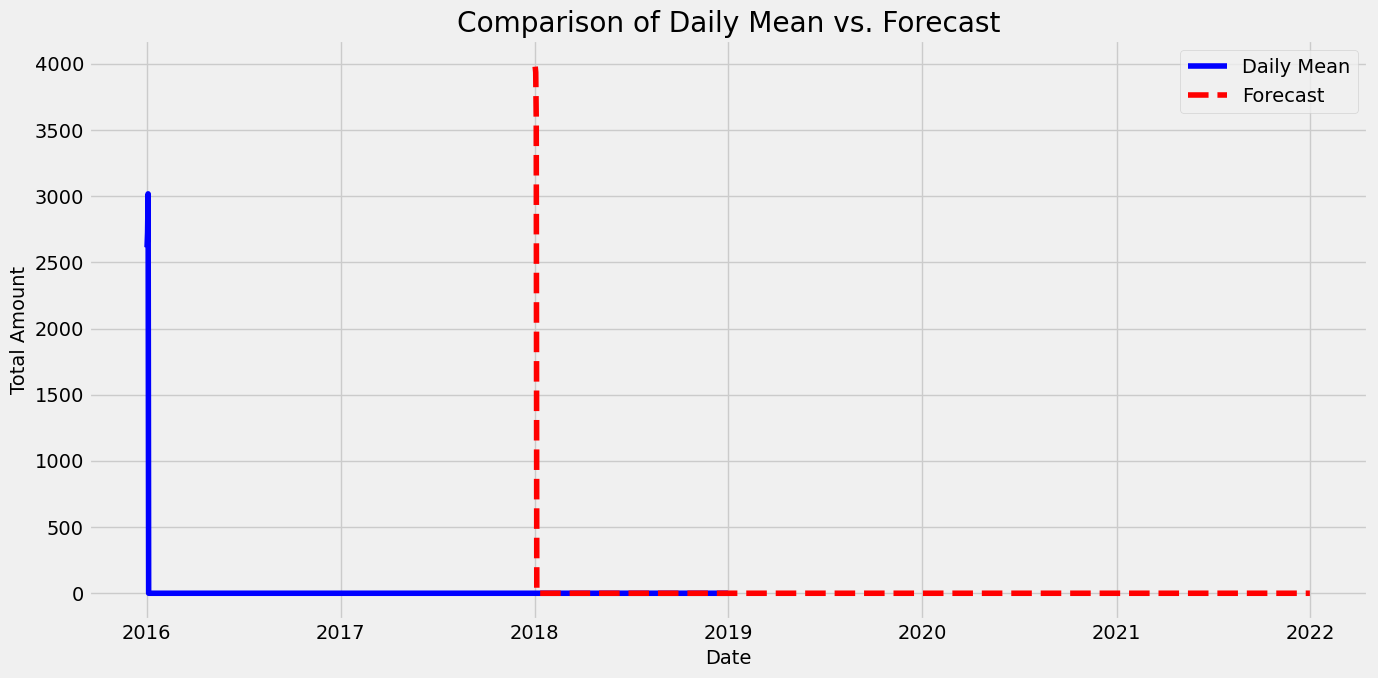

In [113]:
# Sample data
df_daily_mean = pd.DataFrame({
    'Txn_date': pd.date_range(start='2016-01-02', periods=1095),
    'Total_Amt': [2614.093696, 2725.942917, 3017.658913] + [0] * 1092  # Using sample values and filling rest with 0
})
df_daily_mean.set_index('Txn_date', inplace=True)

# Sample forecast
forecast = pd.DataFrame({
    'ds': pd.date_range(start='2018-01-02', periods=1460),
    'yhat': [3978.532033, 3936.350503, 3577.595224] + [0] * 1457  # Using sample values and filling rest with 0
})

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df_daily_mean.index, df_daily_mean['Total_Amt'], label="Daily Mean", color="blue")
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="red", linestyle="--")
plt.title("Comparison of Daily Mean vs. Forecast")
plt.ylabel("Total Amount")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [193]:
forecast.to_csv('forecast_test.csv')

In [194]:
merged.to_csv('merged_test.csv')

In [195]:
df_daily.to_csv('daily_test.csv')